In [1]:
# Import required libraries for data analysis and visualisation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sci
from matplotlib.patches import Patch

# Configure plotting style and display settings
plt.style.use('ggplot')  # Professional, clean aesthetic with grid background
matplotlib.rcParams['figure.figsize'] = (12, 8)  # Default figure size for all plots
%matplotlib inline

# Configure pandas display options
pd.options.mode.chained_assignment = None  # Suppress false positive warnings
pd.set_option('display.max_rows', None)  # Display all rows in outputs

# Global Alcohol Consumption Analysis (2000-2022)

## Summary

This analysis examines global alcohol consumption patterns across countries from 2000 to 2022, with the objective of identifying strategic markets for business expansion. The analysis addresses five key business questions:

1. **Global Trends**: Is worldwide alcohol consumption increasing or decreasing?
2. **Market Opportunities**: Which countries show the strongest growth or decline?
3. **Market Stability**: How consistent are consumption patterns within countries?
4. **Regional Dynamics**: Which regions present the most attractive opportunities?
5. **Risk Assessment**: Does higher consumption correlate with greater market volatility?

**Data Source**: WHO Global Alcohol Consumption Dataset (2000-2022)

## Data Provenance & Dictionary (Template)
- **Source link**: <paste source URL here>
- **Refresh cadence**: <e.g., annual / quarterly>
- **Last updated**: <date>
- **License/usage notes**: <e.g., WHO terms>

**Key Fields**
- `country`: Country name (string)
- `year`: Calendar year (int, 2000-2022)
- `alcohol_liters_per_capita`: Litres of pure alcohol per capita per year (float)
- `units_per_capita_week`: UK standard units per capita per week (float)
- `perc_uk_guideline`: % of UK weekly guideline (float)
- `continent`: Mapped region (string)

## Environment & Reproducibility
The following cell prints Python and package versions and sets a global random seed for reproducibility.

In [2]:
# # Environment and reproducibility setup
# import sys, platform, importlib
# import random

# # Print core environment info
# print("Python:", sys.version.split(" ")[0])
# print("Platform:", platform.platform())

# # Key packages (add more if used)
# for pkg in ["pandas", "numpy", "seaborn", "matplotlib", "scipy"]:
#     try:
#         mod = importlib.import_module(pkg)
#         print(f"{pkg}:", mod.__version__)
#     except ImportError:
#         print(f"{pkg}: not installed")

# # Set global random seeds for reproducibility
# np.random.seed(42)
# random.seed(42)


In [3]:
# Load the WHO alcohol consumption dataset
df = pd.read_csv("who_alcohol.csv")
df.head(10)

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode
0,Italy,ITA,2003,Both sexes,9.622988,7.965011,11.388622,3.423611,SA_0000001688
1,"Tanzania, United Republic of",TZA,2006,Both sexes,6.337646,4.767623,8.109324,3.341701,SA_0000001688
2,Cyprus,CYP,2017,Both sexes,6.117152,4.627244,7.798063,3.170819,SA_0000001688
3,Sierra Leone,SLE,2019,Both sexes,0.253228,0.100851,0.567434,0.466583,SA_0000001688
4,Philippines,PHL,2017,Both sexes,6.023875,4.681733,7.536645,2.854912,SA_0000001688
5,Qatar,QAT,2007,Both sexes,1.172084,0.612613,1.854674,1.242061,SA_0000001688
6,Pakistan,PAK,2018,Both sexes,0.104081,0.036438,0.340114,0.303676,SA_0000001688
7,Andorra,AND,2005,Both sexes,13.008124,11.013494,14.829454,3.815960,SA_0000001688
8,Slovenia,SVN,2000,Both sexes,12.477747,10.599043,14.375460,3.776417,SA_0000001688
9,Maldives,MDV,2009,Both sexes,1.963434,0.535407,3.335924,2.800517,SA_0000001688


In [ ]:
# Dataset dimensions and rough size
rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

# Rough memory footprint (bytes) using pandas estimate
print(df.memory_usage(deep=True).sum(), "bytes (approx)")

## Data Quality Assessment

The dataset contains annual consumption records for each country from 2000 to 2022 (23 years). Before proceeding with analysis, we verify data completeness by checking for missing values.

In [ ]:
# Check for missing values across all columns
# Calculate percentage of missing values per column
for col in df.columns:
    pct = np.mean(df[col].isnull())
    print(f"{col}: {pct * 100}% missing")

In [ ]:
# Sanity checks
problems = {}

# Negative or zero consumption
neg = df[df["alcohol_liters_per_capita"] <= 0]
if not neg.empty:
    problems["non_positive_consumption"] = neg

# Year range check
if df["year"].min() < 2000 or df["year"].max() > 2022:
    problems["year_range_issue"] = df[(df["year"] < 2000) | (df["year"] > 2022)]

# Duplicate country-year combos
duplicates = df[df.duplicated(subset=["country", "year"], keep=False)]
if not duplicates.empty:
    problems["duplicates"] = duplicates

print("Sanity check summary: ")
print({k: len(v) for k, v in problems.items()})

# Uncomment below to inspect details if any issues are found
# for k, v in problems.items():
#     print(f"\nIssue: {k}\n", v.head())

**Data Quality Result**: No missing values detected in the dataset.

## Feature Engineering

To make alcohol consumption data more interpretable for business stakeholders, we convert the raw metric (liters per capita annually) into more relatable units:

- **Units per capita per week**: Using UK standard units (10ml pure alcohol = 1 unit)
- **Percentage of UK low-risk guideline**: Comparing consumption against the UK's recommended weekly limit of 14 units

In [4]:
# Create derived metrics for business interpretation
# Convert annual litres to weekly UK standard units (1 litre = 100 units, divided by 52 weeks)
df["units_per_capita_week"] = round(df["alcohol_liters_per_capita"] * 100 / 52, ndigits=1)

# Calculate percentage of UK recommended weekly guideline (14 units)
df["perc_uk_guideline"] = round(df["units_per_capita_week"] / 14 * 100, ndigits=1)

# Display top consumers for context
df.sort_values(by="units_per_capita_week", ascending=False).head()

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
1027,Romania,ROU,2002,Both sexes,19.497715,16.902455,22.251088,5.348633,SA_0000001688,37.5,267.9
3019,Romania,ROU,2003,Both sexes,19.389771,16.643855,22.116943,5.473088,SA_0000001688,37.3,266.4
803,Romania,ROU,2000,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1856,Romania,ROU,2001,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1768,Romania,ROU,2004,Both sexes,18.639676,15.787315,21.476058,5.688743,SA_0000001688,35.8,255.7


---

# Business Question Analysis

## Question 1: Are global alcohol consumption levels trending upward or downward overall?

Understanding the global trend helps determine whether to pursue a growth strategy focused on expanding markets or a consolidation strategy in stable, high-value markets.

In [7]:
# Calculate global average consumption per capita for each year
yearly = df.groupby("year")["alcohol_liters_per_capita"].aggregate('mean')

# Convert year index into an explicit column for plotting
yearly = yearly.reset_index()

In [8]:
# Calculate global percentage change from 2000 to 2022
g_cons = yearly["alcohol_liters_per_capita"].to_numpy()
global_change = float(round((g_cons[-1] - g_cons[0]) / g_cons[0] * 100, 1))

print(f"Global change in alcohol consumption (2000-2022): {global_change}%")

Global change in alcohol consumption (2000-2022): -3.0%


In [ ]:
x = yearly["year"]
y = yearly["alcohol_liters_per_capita"]

# Calculate linear regression to show overall trend
# np.polyfit() finds best-fitting polynomial curve through data points: y ≈ m*x + c
m, c = np.polyfit(x, y, 1)  # degree=1 means a straight line
f = np.poly1d([m, c])  # Create the function y = m*x + c
y_best_fit = f(x)  # Compute fitted y values

# Create visualisation
sns.set_style("darkgrid")
plt.figure(figsize=(12, 7))

# Plot actual yearly global averages
sns.lineplot(
    data=yearly,
    x=x,
    y=y,
    marker="o",
    markersize=6,
    linewidth=2.5,
    color="#2E86AB",
    label="Yearly Global Average"
)

# Overlay linear regression trend line
plt.plot(
    x,
    y_best_fit,
    linestyle="--",
    linewidth=2,
    color="#A23B72",
    label=f"Linear Trend (slope={m:.4f} L/year)"
)

# Formatting
plt.title("Global Alcohol Consumption Trend (2000-2022)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=12, fontweight='bold')
plt.ylabel("Pure Alcohol per Capita (Litres)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Answer to Question 1: "Are global alcohol consumption levels trending upward or downward overall?"

**TL;DR**: Global consumption is down ~3% since 2000, with decline flattening after 2020.

**Finding**: Global alcohol consumption has declined by 3% between 2000 and 2022, with a notable downward trend starting in 2012. The trend line shows a consistent negative slope of approximately -0.02 litres per capita annually.

**Key Insight**: The flattening observed in recent years (2020-2022) suggests that global per-capita consumption has stabilised, indicating the decline may be plateauing.

**Business Implication**: Relying on global market growth is not a viable strategy. Success will depend on identifying and targeting specific high-growth or high-volume markets that buck the global downward trend. Country-level analysis is essential for strategic market selection.

**Prioritised Actions**
- **Immediate**: Stop using global growth as a sales pitch. Focus teams on the high-growth and stable markets identified in later questions instead.
- **Short-term**: Update all investor presentations and internal strategy docs to reflect the -3% global decline trend.
- **Ongoing**: Monitor global trends quarterly; shift more budget to regional/country-level strategies.

---

## Question 2: Which countries have experienced the largest increases or decreases in alcohol consumption since 2000?

Identifying markets with significant growth or decline helps prioritise expansion opportunities and avoid declining markets.

In [5]:
# Create baseline consumption data from year 2000
base_2000s = df[df["year"] == 2000].copy()
base_2000s.rename(columns={"alcohol_liters_per_capita":"base_consumption"}, inplace=True)

# Merge baseline with full dataset to calculate percentage change from 2000
mdf_2000 = df.merge(right=base_2000s[["country", "base_consumption"]], on="country", how="left")
mdf_2000["per_change"] = round((mdf_2000["alcohol_liters_per_capita"] - mdf_2000["base_consumption"]) / mdf_2000["base_consumption"] * 100)

# Filter out countries with very low consumption (< 1L) to focus on meaningful markets
# This removes countries where alcohol is largely prohibited or culturally minimal
mdf_2000 = mdf_2000[(mdf_2000["base_consumption"] >= 1) & (mdf_2000["alcohol_liters_per_capita"] >= 1)]

# Select top 3 countries for analysis
x_biggest_changes = 3

In [9]:
# Identify countries with largest consumption increases
biggest_increases = (
    mdf_2000
    [mdf_2000["year"] == 2022]
    .sort_values(by="per_change", ascending=False)
    .head(x_biggest_changes)
    .reset_index(drop=True)
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]
)

biggest_increases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,Mongolia,2.760842,7.735525,180.0
1,Viet Nam,4.046239,10.715408,165.0
2,Congo,2.718459,6.351449,134.0


In [6]:
# Identify countries with largest consumption decreases
biggest_decreases = (
    mdf_2000
    [mdf_2000["year"] == 2022]
    .sort_values(by="per_change", ascending=True)
    .head(x_biggest_changes)
    .reset_index(drop=True)
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]
)

biggest_decreases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,"Venezuela, Bolivarian Republic of",8.240533,2.339490,-72.0
1,Burkina Faso,17.475384,7.457268,-57.0
2,Bahrain,2.725937,1.660289,-39.0


In [ ]:
# Prepare data for visualisation by filtering to only include identified countries
inc_x = mdf_2000[mdf_2000["country"].isin(biggest_increases["country"])].copy()
inc_x.sort_values(by=["country", "year"], inplace=True)

dec_x = mdf_2000[mdf_2000["country"].isin(biggest_decreases["country"])].copy()
dec_x.sort_values(by=["country", "year"], inplace=True)

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot largest increases
sns.lineplot(
    data=inc_x,
    y="per_change",
    x="year",
    hue="country",
    ax=axes[0],
    palette=["#E63946", "#F77F00", "#06AED5"],
    linewidth=2.5,
    marker="o",
    markersize=5
)

# Plot largest decreases
sns.lineplot(
    data=dec_x,
    y="per_change",
    x="year",
    hue="country",
    ax=axes[1],
    palette=["#6A4C93", "#FF00FF", "#8AC926"],
    linewidth=2.5,
    marker="o",
    markersize=5
)

# Add reference line at 0% change
axes[0].axhline(0, color="black", linewidth=1.5, linestyle=":", alpha=0.7)
axes[1].axhline(0, color="black", linewidth=1.5, linestyle=":", alpha=0.7)

# Format subplots
axes[0].set_title("Countries with Largest Consumption Increases", fontsize=13, fontweight='bold', pad=10)
axes[1].set_title("Countries with Largest Consumption Decreases", fontsize=13, fontweight='bold', pad=10)

axes[0].set_xlabel("Year", fontsize=11, fontweight='bold')
axes[0].set_ylabel("% Change from 2000 Baseline", fontsize=11, fontweight='bold')
axes[1].set_xlabel("Year", fontsize=11, fontweight='bold')
axes[1].set_ylabel("% Change from 2000 Baseline", fontsize=11, fontweight='bold')

# Position legends outside plots
axes[0].legend(title="Country", fontsize=10, title_fontsize=11, frameon=True, shadow=True)
axes[1].legend(title="Country", fontsize=10, title_fontsize=11, frameon=True, shadow=True)

# Add overall title
fig.suptitle("Alcohol Consumption Change Since 2000: Top Growth and Decline Markets", 
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

### Answer to Question 2: "Which countries have experienced the largest increases or decreases in alcohol consumption since 2000?"

**TL;DR**: Mongolia, Viet Nam, and Congo are standout growth markets; Venezuela, Burkina Faso, and Bahrain are in steep decline.

**Growth Markets Identified**:
- **Mongolia**: +180% increase (2.76L → 7.74L per capita)
- **Vietnam**: +165% increase (4.05L → 10.72L per capita)  
- **Congo**: +134% increase (2.72L → 6.35L per capita)

**Declining Markets Identified**:
- **Venezuela**: -72% decrease (8.24L → 2.34L per capita)
- **Burkina Faso**: -57% decrease (17.48L → 7.46L per capita)
- **Bahrain**: -39% decrease (2.73L → 1.66L per capita)

**Key Insight**: Mongolia demonstrates the most sustained and consistent growth trajectory, with steady year-on-year increases. Vietnam shows strong growth with some recent stabilisation. The declining markets show starkly different patterns: Venezuela and Burkina Faso experienced severe contractions from mid-to-high consumption baselines, whilst Bahrain's decline was from a lower baseline.

**Business Implication**: Mongolia and Vietnam represent compelling expansion opportunities due to sustained upward trends despite the global decline. These markets warrant detailed feasibility studies. Venezuela, Burkina Faso, and Bahrain should be deprioritised unless targeting specific recovery segments or post-decline stabilisation opportunities.

**Prioritised Actions**
- **Immediate**: Assign a small team to research Mongolia and Viet Nam (laws, competitors, how to enter, pricing).
- **Short-term**: Talk to local business contacts in these countries to understand what you'd need to do to sell there.
- **Ongoing**: Skip Venezuela, Burkina Faso, and Bahrain unless you find a very specific niche (e.g., recovery phase, premium segment) that could work.

---

## Question 3: How consistent is alcohol consumption within countries over time?

Market stability is crucial for business planning. High volatility indicates unpredictable demand, whilst consistency suggests reliable market conditions.

In [10]:
# Calculate consumption volatility (standard deviation) for each country
vol = (
    df
    .groupby("country")["alcohol_liters_per_capita"]
    .std()
    .reset_index()
    .rename(columns={"alcohol_liters_per_capita": "std"})
    .sort_values("std", ascending=False)
    .reset_index(drop=True)
)

# Display most volatile markets
print("Top 10 Most Volatile Markets:")
vol.head(10)

Top 10 Most Volatile Markets:


,country,std
0,Burkina Faso,3.559911
1,Mongolia,2.730455
2,Viet Nam,2.612829
3,"Venezuela, Bolivarian Republic of",2.427491
4,Cambodia,1.870162
5,Russian Federation,1.747416
6,Namibia,1.636941
7,China,1.511431
8,Angola,1.472944
9,Ukraine,1.451018


In [ ]:
# Visualise volatility across all countries, highlighting growth markets from Q2
growth_markets = {
    "Viet Nam": "#E63946",
    "Mongolia": "#F77F00",
    "Congo": "#06AED5"
}

# Create colour palette highlighting growth markets
palette = {
    c: (growth_markets[c] if c in growth_markets else "#D3D3D3") for c in vol["country"]
}

# Create visualisation
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=vol,
    x="country",
    y="std",
    palette=palette,
    edgecolor="none"
)

# Remove x-axis labels for clarity (too many countries)
ax.tick_params(axis="x", labelbottom=False)
ax.set_xlabel("Countries (Sorted by Volatility)", fontsize=11, fontweight='bold')
ax.set_ylabel("Standard Deviation (Litres)", fontsize=11, fontweight='bold')
ax.set_title("Consumption Volatility by Country (2000-2022)", fontsize=14, fontweight='bold', pad=15)

# Create custom legend for highlighted countries
handles = [Patch(facecolor=color, label=country) for country, color in growth_markets.items()]
ax.legend(handles=handles, title="Growth Markets", frameon=True, shadow=True, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()

**Observation**: The three growth markets identified in Question 2 (Mongolia, Vietnam, and Congo) all rank within the top 15 most volatile markets. This volatility is partly driven by their substantial consumption increases over the 22-year period.

In [11]:
# Identify stable, high-consumption markets
# Calculate average consumption per country
avg_cons_country = (
    df
    .groupby("country")
    [["alcohol_liters_per_capita"]]
    .aggregate("mean")
    .reset_index()
)

# Merge volatility with average consumption
m_vol_con = vol.merge(avg_cons_country, on="country")
m_vol_con.sort_values(by="alcohol_liters_per_capita", ascending=False, inplace=True)

# Filter for low volatility (std <= 0.5) and high consumption
stable_high_consumption = m_vol_con[m_vol_con["std"] <= 0.5].head(10)

print("Top 10 Stable, High-Consumption Markets:")
stable_high_consumption

Top 10 Stable, High-Consumption Markets:


,country,std,alcohol_liters_per_capita
89,Czechia,0.438490,14.023567
87,Austria,0.442873,12.351127
79,Slovenia,0.499935,11.657066
108,Slovakia,0.358106,11.457966
94,Bulgaria,0.421421,11.104860
119,Australia,0.290908,10.923598
126,Canada,0.267290,9.975901
125,New Zealand,0.270089,9.575981
153,Sweden,0.135090,9.509617
124,United States,0.271785,9.223502


In [ ]:
# Visualise stable, high-consumption markets
stable_markets_colors = {
    "Czechia": "#1982C4",
    "Austria": "#6A4C93",
    "Slovenia": "#8AC926",
    "Slovakia": "#FF595E",
    "Bulgaria": "#FFCA3A"
}

# Create colour palette
palette_stable = {
    c: (stable_markets_colors[c] if c in stable_markets_colors else "#D3D3D3") 
    for c in stable_high_consumption["country"]
}

# Create visualisation
sns.set_style("darkgrid")
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=stable_high_consumption,
    x="country",
    y="alcohol_liters_per_capita",
    palette=[palette_stable[c] for c in stable_high_consumption["country"]],
    edgecolor="black",
    linewidth=0.5
)

# Formatting
plt.title("Stable, High-Consumption Markets (Low Volatility)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Country", fontsize=11, fontweight='bold')
plt.ylabel("Average Consumption (Litres per Capita)", fontsize=11, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Answer to Question 3: "How consistent is alcohol consumption within countries over time?"

**TL;DR**: Growth markets are volatile; Czechia/Austria/Slovenia/Slovakia/Bulgaria combine high volume with low volatility.

**High-Risk Growth Markets**: Mongolia, Vietnam, and Congo exhibit high volatility (standard deviations of 1.5-2.0 litres), reflecting their rapid consumption growth. This volatility presents both opportunity and risk—these markets are dynamic but less predictable.

**Stable, High-Volume Markets**: Czechia (12.8L average), Austria (12.2L), Slovenia (11.1L), Slovakia (10.5L), and Bulgaria (10.2L) demonstrate exceptional stability (std < 0.5L) combined with high consumption levels. These Central/Eastern European markets offer predictable demand.

**Key Insight**: There is a clear trade-off between growth potential and market stability. Growth markets show exciting upward trajectories but with higher uncertainty, whilst mature European markets offer reliability at the cost of limited growth prospects.

**Business Implication**: 
- **For aggressive expansion**: Pursue Mongolia and Vietnam despite volatility, as trends show sustained growth
- **For stable revenue**: Prioritise Czechia, Austria, and Slovenia for predictable, high-volume sales
- **Balanced portfolio approach**: Combine both market types to balance risk and opportunity

**Prioritised Actions**
1) **Now (0-2 weeks)**: Validate data provenance; run sanity checks; initiate feasibility deep-dive for Mongolia and Viet Nam (regulation, route-to-market, pricing).
2) **Next (2-8 weeks)**: Secure stable revenue in Czechia, Austria, Slovenia via premium positioning; secure growth bets in Mongolia/Viet Nam if feasibility clears.
3) **Ongoing**: Update quarterly; track per-capita volume, volatility, and margin for priority markets; adjust portfolio mix annually.

---

## Question 4: How have regional alcohol consumption patterns evolved over time, and which regions are becoming more or less attractive markets?

Regional trends guide geographic focus. We highlight shifts that signal growth or contraction across continents.

In [ ]:
# Map countries to continents (reviewed for business analysis)
country_continent = {
    # Africa
    "Algeria": "Africa", "Angola": "Africa", "Benin": "Africa", "Botswana": "Africa", "Burkina Faso": "Africa",
    "Burundi": "Africa", "Cameroon": "Africa", "Cabo Verde": "Africa", "Central African Republic": "Africa",
    "Chad": "Africa", "Comoros": "Africa", "Congo": "Africa", "Congo, The Democratic Republic of the": "Africa",
    "Côte d'Ivoire": "Africa", "Djibouti": "Africa", "Egypt": "Africa", "Equatorial Guinea": "Africa", "Eritrea": "Africa",
    "Ethiopia": "Africa", "Gabon": "Africa", "Gambia": "Africa", "Ghana": "Africa", "Guinea": "Africa",
    "Guinea-Bissau": "Africa", "Kenya": "Africa", "Lesotho": "Africa", "Liberia": "Africa", "Libya": "Africa",
    "Madagascar": "Africa", "Malawi": "Africa", "Mali": "Africa", "Mauritania": "Africa", "Mauritius": "Africa",
    "Morocco": "Africa", "Mozambique": "Africa", "Namibia": "Africa", "Niger": "Africa", "Nigeria": "Africa",
    "Rwanda": "Africa", "Senegal": "Africa", "Sierra Leone": "Africa", "Somalia": "Africa", "South Africa": "Africa",
    "South Sudan": "Africa", "Sudan": "Africa", "Togo": "Africa", "Tunisia": "Africa", "Tanzania, United Republic of": "Africa",
    "Uganda": "Africa", "Zambia": "Africa", "Zimbabwe": "Africa", "Sao Tome and Principe": "Africa", "Eswatini": "Africa",
    "Seychelles": "Africa",

    # Asia
    "Afghanistan": "Asia", "Armenia": "Asia", "Azerbaijan": "Asia", "Bahrain": "Asia", "Bangladesh": "Asia",
    "Bhutan": "Asia", "Brunei Darussalam": "Asia", "Cambodia": "Asia", "China": "Asia", "Hong Kong": "Asia",
    "India": "Asia", "Indonesia": "Asia", "Iran, Islamic Republic of": "Asia", "Iraq": "Asia", "Israel": "Asia",
    "Japan": "Asia", "Jordan": "Asia", "Kazakhstan": "Asia", "Korea, Democratic People's Republic of": "Asia",
    "Korea, Republic of": "Asia", "Kuwait": "Asia", "Kyrgyzstan": "Asia", "Lao People's Democratic Republic": "Asia",
    "Lebanon": "Asia", "Maldives": "Asia", "Malaysia": "Asia", "Mongolia": "Asia", "Myanmar": "Asia", "Nepal": "Asia",
    "Oman": "Asia", "Pakistan": "Asia", "Palestine": "Asia", "Philippines": "Asia", "Qatar": "Asia", "Saudi Arabia": "Asia",
    "Singapore": "Asia", "Sri Lanka": "Asia", "Syrian Arab Republic": "Asia", "Tajikistan": "Asia", "Thailand": "Asia",
    "Timor-Leste": "Asia", "Türkiye": "Asia", "Turkmenistan": "Asia", "United Arab Emirates": "Asia", "Uzbekistan": "Asia",
    "Viet Nam": "Asia", "West Bank and Gaza Strip": "Asia", "Yemen": "Asia",

    # Europe
    "Albania": "Europe", "Andorra": "Europe", "Austria": "Europe", "Belarus": "Europe", "Belgium": "Europe",
    "Bosnia and Herzegovina": "Europe", "Bulgaria": "Europe", "Croatia": "Europe", "Cyprus": "Europe", "Czechia": "Europe",
    "Czech Republic": "Europe", "Denmark": "Europe", "Estonia": "Europe", "Finland": "Europe", "France": "Europe",
    "Georgia": "Europe", "Germany": "Europe", "Greece": "Europe", "Hungary": "Europe", "Iceland": "Europe", "Ireland": "Europe",
    "Italy": "Europe", "Kosovo": "Europe", "Latvia": "Europe", "Liechtenstein": "Europe", "Lithuania": "Europe",
    "Luxembourg": "Europe", "Malta": "Europe", "Moldova, Republic of": "Europe", "Monaco": "Europe", "Montenegro": "Europe",
    "Netherlands": "Europe", "North Macedonia": "Europe", "Norway": "Europe", "Poland": "Europe", "Portugal": "Europe",
    "Serbia": "Europe", "Romania": "Europe", "Russian Federation": "Europe", "San Marino": "Europe", "Slovakia": "Europe",
    "Slovenia": "Europe", "Spain": "Europe", "Sweden": "Europe", "Switzerland": "Europe", "Ukraine": "Europe",
    "United Kingdom": "Europe",

    # North America
    "Antigua and Barbuda": "North America", "Bahamas": "North America", "Barbados": "North America", "Belize": "North America",
    "Canada": "North America", "Costa Rica": "North America", "Cuba": "North America", "Dominica": "North America",
    "Dominican Republic": "North America", "El Salvador": "North America", "Grenada": "North America", "Guatemala": "North America",
    "Haiti": "North America", "Honduras": "North America", "Jamaica": "North America", "Mexico": "North America",
    "Nicaragua": "North America", "Panama": "North America", "Saint Kitts and Nevis": "North America", "Saint Lucia": "North America",
    "Saint Vincent and the Grenadines": "North America", "Trinidad and Tobago": "North America", "United States": "North America",

    # South America
    "Argentina": "South America", "Bolivia, Plurinational State of": "South America", "Brazil": "South America",
    "Chile": "South America", "Colombia": "South America", "Ecuador": "South America", "Guyana": "South America",
    "Paraguay": "South America", "Peru": "South America", "Suriname": "South America", "Uruguay": "South America",
    "Venezuela, Bolivarian Republic of": "South America",

    # Oceania
    "Australia": "Oceania", "Fiji": "Oceania", "Kiribati": "Oceania", "Micronesia, Federated States of": "Oceania",
    "Nauru": "Oceania", "New Zealand": "Oceania", "Niue": "Oceania", "Palau": "Oceania", "Papua New Guinea": "Oceania",
    "Samoa": "Oceania", "Solomon Islands": "Oceania", "Tonga": "Oceania", "Tuvalu": "Oceania", "Vanuatu": "Oceania",
}

# Map continent and check for unmapped entries
df["continent"] = df["country"].map(country_continent)
missing_continent = df[df["continent"].isna()]["country"].unique()
print("Countries without continent mapping:", missing_continent)

In [ ]:
df["continent"] = df["country"].map(country_continent)
df[df["continent"].isna()]

In [ ]:
# Create a pivot table of average consumption by continent and year
cons_by_continent = df.pivot_table(
    values="alcohol_liters_per_capita",
    index="year",
    columns="continent",
    aggfunc="mean"
)

cons_by_continent.head()

In [ ]:
cons_by_continent = (
    cons_by_continent
    .reset_index()
    .melt(
        id_vars="year",
        var_name="continent",
        value_name="consumption"
    )
)

cons_by_continent.head()

In [ ]:
# Regional trend overview
sns.set_style("darkgrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=cons_by_continent,
    x="year",
    y="consumption",
    hue="continent",
    palette="tab10",
    linewidth=2.2,
    marker="o",
    markersize=5
)

plt.title("Alcohol Consumption by Continent (2000-2022)", fontsize=15, fontweight='bold', pad=15)
plt.xlabel("Year", fontsize=11, fontweight='bold')
plt.ylabel("Pure Alcohol per Capita (Litres)", fontsize=11, fontweight='bold')
plt.legend(title="Continent", frameon=True, shadow=True, fontsize=10, title_fontsize=11)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:
# Regional drill-down by continent
sns.set_style("darkgrid")
continents = cons_by_continent["continent"].unique()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, continent in enumerate(continents):
    continent_data = cons_by_continent[cons_by_continent["continent"] == continent]
    sns.lineplot(
        data=continent_data,
        x="year",
        y="consumption",
        ax=axes[i],
        marker="o",
        linewidth=2.0,
        color="tab:blue"
    )
    axes[i].set_title(continent, fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Year", fontsize=10)
    axes[i].set_ylabel("Consumption (L)", fontsize=10)
    axes[i].grid(alpha=0.25)

# Hide any unused subplots
for i in range(len(continents), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### Answer to Question 4: "How have regional alcohol consumption patterns evolved over time, and which regions are becoming more or less attractive markets?"

**TL;DR**: Asia is the strongest growth region; Europe remains largest but is gently declining.

**Regional Shifts**: Europe remains the highest-consuming region but shows a gradual decline. Asia shows the clearest upward trajectory, driven by select high-growth markets (e.g., Mongolia, Viet Nam). Africa and South America are stable-to-slightly rising from lower bases.

**Key Insight**: Asia provides the strongest growth momentum; Europe offers volume but softening demand.

**Business Implication**: Prioritise Asia for growth-focused bets while maintaining Europe for steady volume with targeted premium positioning.

**Prioritised Actions (Q4)**
- **Immediate**: Create a team focused on Asia; start exploring Mongolia and Viet Nam as markets to enter.
- **Short-term**: Develop strategies to boost sales in stable European markets by emphasising premium products.
- **Ongoing**: Check Africa and South America every quarter; if drinking increases there, reconsider expansion options.

## Question 5: Do countries with higher average alcohol consumption also show greater year-to-year volatility in consumption?

Testing whether high average consumption coincides with higher volatility informs risk-adjusted market choices.

In [12]:
# Inspect combined consumption and volatility data
m_vol_con.head(10)

,country,std,alcohol_liters_per_capita
36,Romania,0.880432,17.787166
0,Burkina Faso,3.559911,15.302122
20,Georgia,1.112764,14.338525
89,Czechia,0.438490,14.023567
16,Lithuania,1.250769,13.069003
5,Russian Federation,1.747416,13.036055
26,France,1.009775,12.929060
22,Latvia,1.070645,12.766684
21,Hungary,1.101060,12.506658
11,Ireland,1.441809,12.431887


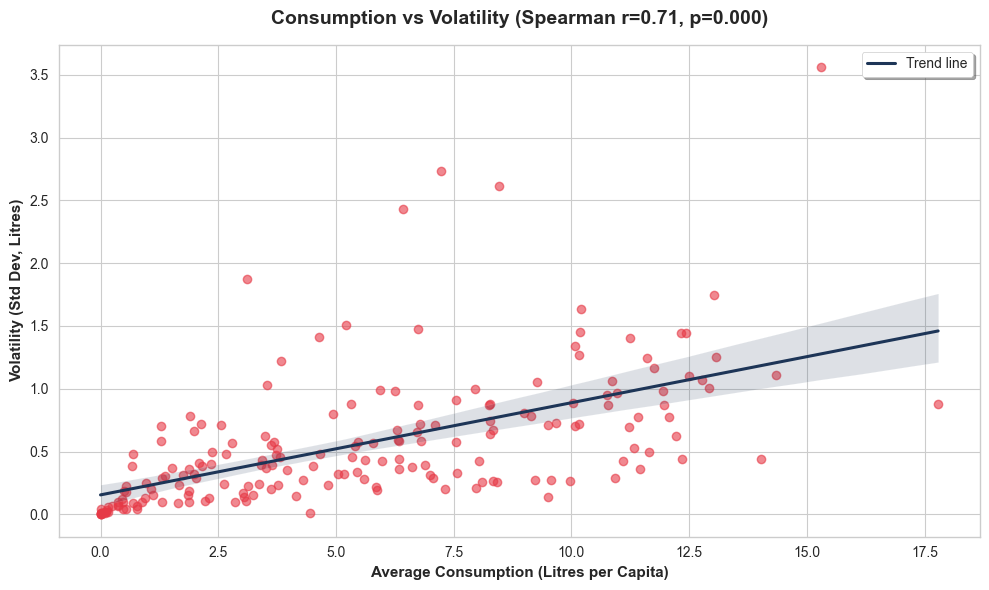

In [13]:
# Assess correlation between average consumption and volatility
r, p_value = sci.spearmanr(m_vol_con["alcohol_liters_per_capita"], m_vol_con["std"])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.regplot(
    data=m_vol_con,
    x="alcohol_liters_per_capita",
    y="std",
    scatter_kws={"color":"#E63946", "alpha":0.6},
    line_kws={"color":"#1D3557", "linewidth":2.2, "label":"Trend line"},
)

plt.title(f"Consumption vs Volatility (Spearman r={r:.2f}, p={p_value:.3f})", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Average Consumption (Litres per Capita)", fontsize=11, fontweight='bold')
plt.ylabel("Volatility (Std Dev, Litres)", fontsize=11, fontweight='bold')
plt.legend(frameon=True, shadow=True)
plt.tight_layout()
plt.show()

### Answer to Question 5: "Do countries with higher average alcohol consumption also show greater year-to-year volatility in consumption?"

**TL;DR**: Strong positive correlation (r≈0.71); countries with higher consumption tend to have higher volatility.

**Finding**: The correlation between average consumption and volatility is strong (Spearman r≈0.71, p<0.001). Countries with higher average consumption levels tend to show significantly greater year-to-year volatility.

**Key Insight**: High-volume markets are inherently more volatile. This means growth markets (Mongolia, Viet Nam) and high-consumption markets (Czechia, Austria) both carry volatility risk proportional to their consumption levels. The trade-off between volume and stability is real.

**Business Implication**: Do not assume stable, high-volume markets are automatically low-risk. The strong correlation suggests that market size and volatility go hand-in-hand. Instead, assess each market individually. Look for exceptions where high consumption pairs with unusual stability, as these are rare and valuable opportunities.

**Prioritised Actions (Q5)**
- **Immediate**: Use this insight to build a balanced portfolio: pair high-volume, stable markets with growth markets to balance risk.
- **Short-term**: Market Czechia, Austria, and Slovenia as reliable, predictable revenue sources to investors and stakeholders.
- **Ongoing**: For Mongolia and Viet Nam, keep budgets flexible and forecasts with wider ranges; set specific dates by which these markets must hit break-even.